In [11]:
# ==========================================================
#  Standard Libraries
# ==========================================================
import os, re, time, glob, json, pickle, warnings
from itertools import combinations
from pathlib import Path

# ==========================================================
#  Data Handling & Computation
# ==========================================================
import numpy as np
import pandas as pd
import joblib

# ==========================================================
#  Visualization & Explainability
# ==========================================================
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from tqdm import tqdm
from IPython.display import display
from matplotlib.lines import Line2D
from matplotlib.ticker import PercentFormatter

# ==========================================================
#  Machine Learning - Core
# ==========================================================
from sklearn.model_selection import (
    StratifiedKFold, cross_val_score, train_test_split
)
from sklearn.preprocessing import (
    StandardScaler, RobustScaler, OneHotEncoder, OrdinalEncoder
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# ==========================================================
#  Evaluation Metrics
# ==========================================================
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score,
    f1_score, confusion_matrix, accuracy_score, precision_score, recall_score,
    classification_report, RocCurveDisplay, PrecisionRecallDisplay
)

# ==========================================================
#  Calibration Display (CORRECTED IMPORT)
# ==========================================================
from sklearn.calibration import CalibrationDisplay

# ==========================================================
#  Imbalanced Data Handling
# ==========================================================
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import TomekLinks

# ==========================================================
#  Machine Learning Models
# ==========================================================
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# ==========================================================
#  Hyperparameter Optimization
# ==========================================================
import optuna
from optuna.pruners import MedianPruner
from optuna.trial import TrialState

# ==========================================================
#  Settings & Configuration
# ==========================================================

# COMPLETE SUPPRESSION OF ALL WARNINGS
warnings.filterwarnings('ignore')

# Suppress specific warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Suppress Optuna completely
optuna.logging.set_verbosity(optuna.logging.CRITICAL)
os.environ['OPTUNA_DISABLE_IMPORT_CHECK'] = '1'

# Suppress LightGBM completely
os.environ['LIGHTGBM_VERBOSE'] = '-1'

# Suppress other libraries
import logging
logging.getLogger('lightgbm').setLevel(logging.ERROR)
logging.getLogger('optuna').setLevel(logging.ERROR)
logging.getLogger('joblib').setLevel(logging.ERROR)
logging.getLogger('matplotlib').setLevel(logging.ERROR)
logging.getLogger('shap').setLevel(logging.ERROR)

# Global settings
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Visualization settings
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['grid.linestyle'] = '--'

# Pandas display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Set style for better visualizations
sns.set_palette("husl")

print("✅ All libraries imported and configured successfully!")
print("🔇 All logs suppressed - Optuna and LightGBM will run silently")
print(f"📊 Random state: {RANDOM_STATE}")

# Verify versions
import sklearn
import imblearn
print(f"🔧 scikit-learn version: {sklearn.__version__}")
print(f"🔧 imbalanced-learn version: {imblearn.__version__}")

✅ All libraries imported and configured successfully!
🔇 All logs suppressed - Optuna and LightGBM will run silently
📊 Random state: 42
🔧 scikit-learn version: 1.5.1
🔧 imbalanced-learn version: 0.14.0


In [12]:
# ------------------------ 1. PROJECT ROOT & DIRECTORIES ------------------------
PROJECT_ROOT = Path(os.environ.get('PROJECT_ROOT', Path.cwd().parent.parent)).resolve()
reports_figures = PROJECT_ROOT / 'reports/modeling/figures'
reports_best_model = PROJECT_ROOT / 'reports/modeling/best model'
artifacts_path = PROJECT_ROOT / 'artifacts'

# Create directories with better feedback
print("📁 Setting up project directories...")
for path in [reports_figures, reports_best_model, artifacts_path]:
    try:
        if not path.exists():
            path.mkdir(parents=True, exist_ok=True)
            print(f"✅ Created directory: {path.relative_to(PROJECT_ROOT)}")
        else:
            print(f"📂 Directory exists: {path.relative_to(PROJECT_ROOT)}")
    except Exception as e:
        print(f"❌ Failed to create directory {path}: {e}")
        raise

# ------------------------ 2. DATA LOADING ------------------------
DATA_PROCESSED_DIR = Path(os.environ.get('DATA_PROCESSED_DIR', PROJECT_ROOT / 'data/processed')).resolve()
data_file = DATA_PROCESSED_DIR / 'processed_data.parquet'

print(f"\n📊 Loading data from: {data_file.relative_to(PROJECT_ROOT)}")

if not data_file.is_file():
    # Provide helpful debugging information
    print(f"❌ Data file not found: {data_file}")
    print(f"🔍 Checking directory contents:")
    if DATA_PROCESSED_DIR.exists():
        files = list(DATA_PROCESSED_DIR.glob('*'))
        if files:
            print("Available files:")
            for f in files:
                print(f"  - {f.name}")
        else:
            print("  Directory is empty")
    else:
        print(f"  Directory does not exist: {DATA_PROCESSED_DIR}")
    
    raise FileNotFoundError(f"Data file not found: {data_file.resolve()}")

print("✅ Data file found and ready to load")

📁 Setting up project directories...
📂 Directory exists: reports\modeling\figures
📂 Directory exists: reports\modeling\best model
📂 Directory exists: artifacts

📊 Loading data from: data\processed\processed_data.parquet
✅ Data file found and ready to load


In [13]:
import logging
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

# Set up a basic logger for notebook use
logger = logging.getLogger("model_training")
if not logger.hasHandlers():
    logger.setLevel(logging.INFO)
    handler = logging.StreamHandler()
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)

def prepare_data(data_path: Path, test_size: float = 0.3, random_state: int = 42):
    """
    Loads and splits the heart disease data, and defines the preprocessor.
    """
    # Load Data
    logger.info(f"Loading data from: {data_path}")
    df = pd.read_parquet(data_path)

    # Define Feature Sets
    numerical_features = [
        'Age_Years', 'Systolic_BP', 'Diastolic_BP', 'BMI', 'Pulse_Pressure',
        'Demographics_Score', 'Clinical_Biomarkers_Score', 'Lifestyle_Score'
    ]
    
    ordinal_features = ['Glucose_Level', 'Cholesterol_Level', 'Age_Group', 'BMI_Category']
    ordinal_categories = [
        ['1', '2', '3'],
        ['1', '2', '3'], 
        ['<40', '41-50', '51-60', '61-70', '>70'],
        ['Underweight', 'Normal', 'Overweight', 'Obese I', 'Obese II+']
    ]
    
    nominal_features = ['Sex', 'Smoking_Status', 'Alcohol_Intake', 'Physical_Activity']
    all_features = numerical_features + ordinal_features + nominal_features

    # Prepare Data for Splitting
    categorical_features = ordinal_features + nominal_features
    df = df.astype({col: str for col in categorical_features})
    
    X = df[all_features]
    y = df['target']

    # Stratified Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # Create and FIT Preprocessing Pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', RobustScaler(), numerical_features),
            ('ord', OrdinalEncoder(
                categories=ordinal_categories, 
                dtype=np.float64, 
                handle_unknown='use_encoded_value', 
                unknown_value=-1
            ), ordinal_features),
            ('nom', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), nominal_features)
        ],
        remainder='drop',
        n_jobs=-1
    )

    # FIT THE PREPROCESSOR on training data
    preprocessor.fit(X_train)
    logger.info("Preprocessor fitted successfully")

    return X_train, X_test, y_train, y_test, preprocessor, all_features

if __name__ == '__main__':
    try:
        PROJECT_ROOT = Path(__file__).resolve().parents[2]
    except NameError:
        PROJECT_ROOT = Path().resolve().parent.parent

    DATA_PATH = PROJECT_ROOT / 'data' / 'processed' / 'processed_data.parquet'

    try:
        X_train, X_test, y_train, y_test, preprocessor, feature_names = prepare_data(data_path=DATA_PATH)

        print("Data preparation completed successfully")
        print(f"Train: {X_train.shape}, Test: {X_test.shape}")
        print(f"Transformed features: {len(preprocessor.get_feature_names_out())}")
        
    except FileNotFoundError as e:
        logger.error(f"File not found: {e}")
    except Exception as e:
        logger.error(f"Error during data preparation: {e}")
        raise

2025-10-13 20:39:47,555 - model_training - INFO - Loading data from: P:\projects\heart_disease_prediction\data\processed\processed_data.parquet
2025-10-13 20:39:50,449 - model_training - INFO - Preprocessor fitted successfully


Data preparation completed successfully
Train: (48983, 16), Test: (20993, 16)
Transformed features: 16


In [14]:
import xgboost as xgb
import lightgbm as lgb
import shutil
import numpy as np
from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
import joblib
import optuna
from sklearn.metrics import roc_auc_score, average_precision_score
import os
from tqdm.auto import tqdm

# ==========================================================
# HEART DISEASE MODELING: XGBoost vs LightGBM (Optuna + Calibration)
# ==========================================================
# Determine Project Root and Reports Folder
current_dir = Path().resolve()
if "src" in [p.name.lower() for p in current_dir.parents]:
    project_root = [p for p in current_dir.parents if p.name.lower() == "src"][0].parent
else:
    project_root = current_dir

SAVE_DIR = project_root / "reports/modeling/best model"

# Only create directory if it doesn't exist
if not SAVE_DIR.exists():
    SAVE_DIR.mkdir(parents=True, exist_ok=True)
    print(f"✅ Created directory: {SAVE_DIR.resolve()}")
else:
    print(f"📁 Directory already exists: {SAVE_DIR.resolve()}")

# ==========================================================
# Remove existing model files if they exist
# ==========================================================
model_files = [
    "xgboost_best_params.pkl",
    "lightgbm_best_params.pkl", 
    "xgboost_calibrated_model.pkl",
    "lightgbm_calibrated_model.pkl",
    "fitted_preprocessor.pkl",
    "model_training_summary.txt"
]

for model_file in model_files:
    file_path = SAVE_DIR / model_file
    if file_path.exists():
        os.remove(file_path)
        print(f"🗑️  Removed existing file: {model_file}")

# ==========================================================
# Enhanced Early Stopping Callback for Optuna with Progress Tracking
# ==========================================================
class EarlyStoppingExceeded(optuna.exceptions.OptunaError):
    pass

class EarlyStoppingCallback:
    def __init__(self, early_stopping_rounds: int, direction: str = "maximize", total_trials: int = 50):
        self.early_stopping_rounds = early_stopping_rounds
        self.direction = direction
        self.total_trials = total_trials
        self._best_value = None
        self._no_improvement_count = 0
        self._current_trial = 0

    def __call__(self, study: optuna.study.Study, trial: optuna.trial.FrozenTrial):
        self._current_trial += 1
        current_value = trial.value
        
        if current_value is None:
            return

        if self._best_value is None:
            self._best_value = current_value
            return

        if self.direction == "maximize":
            improved = current_value > self._best_value
        else:
            improved = current_value < self._best_value

        if improved:
            self._best_value = current_value
            self._no_improvement_count = 0
        else:
            self._no_improvement_count += 1

        # Only stop early if we've completed at least 10 trials and no improvement for specified rounds
        if (self._current_trial >= 10 and 
            self._no_improvement_count >= self.early_stopping_rounds and
            self._current_trial < self.total_trials):
            raise EarlyStoppingExceeded()

# ==========================================================
# Custom Wrapper for Progress Bar in Optuna Optimization
# ==========================================================
def optimize_with_progress(study, objective, n_trials, callbacks, model_name):
    pbar = tqdm(total=n_trials, desc=f"🔍 {model_name} Optimization", position=0, leave=True)
    
    def callback_with_progress(study, trial):
        pbar.update(1)
        pbar.set_postfix({
            "Best Score": f"{study.best_value:.4f}",
            "Trial": f"{trial.number + 1}/{n_trials}"
        })
        for cb in callbacks:
            cb(study, trial)
    
    try:
        study.optimize(objective, n_trials=n_trials, callbacks=[callback_with_progress])
    except EarlyStoppingExceeded:
        pbar.set_description(f"✅ {model_name} - Early Stopping")
    finally:
        pbar.close()

# ==========================================================
# BALANCED XGBoost Objective Function - Moderate Regularization
# ==========================================================
def objective_xgb(trial):
    params = {
        # Balanced tree complexity
        "n_estimators": trial.suggest_int("n_estimators", 200, 800),
        "max_depth": trial.suggest_int("max_depth", 4, 8),  # Moderate depth
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.15),
        
        # Moderate sampling - not too aggressive
        "subsample": trial.suggest_float("subsample", 0.75, 0.95),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.75, 0.95),
        
        # Light regularization - enough to prevent overfitting but not underfitting
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),  # Reduced range
        "reg_lambda": trial.suggest_float("reg_lambda", 0.5, 2.0),  # Start from 0.5
        
        # Gentle additional regularization
        "gamma": trial.suggest_float("gamma", 0.0, 0.5),  # Reduced max
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 5),  # Small range
        
        "random_state": 42,
        "tree_method": "hist",
        "n_jobs": -1,
        "eval_metric": "logloss",
        "verbosity": 0
    }
    
    model = xgb.XGBClassifier(**params)
    pipe = Pipeline([("preprocessor", preprocessor), ("model", model)])
    
    # Use stratified CV for robust validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)
    
    return np.mean(scores)  # No penalty - let cross-validation speak for itself

# ==========================================================
# BALANCED LightGBM Objective Function - Moderate Regularization
# ==========================================================
def objective_lgb(trial):
    params = {
        # Balanced parameters
        "n_estimators": trial.suggest_int("n_estimators", 200, 800),
        "num_leaves": trial.suggest_int("num_leaves", 20, 50),  # Moderate complexity
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.15),
        
        # Moderate feature sampling
        "subsample": trial.suggest_float("subsample", 0.75, 0.95),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.75, 0.95),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 5),
        
        # Light regularization
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.5, 2.0),
        
        # Gentle tree constraints
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 30),  # Not too restrictive
        "min_child_weight": trial.suggest_float("min_child_weight", 0.001, 0.1),
        "min_split_gain": trial.suggest_float("min_split_gain", 0.0, 0.2),
        
        "random_state": 42,
        "device": "cpu",
        "n_jobs": -1,
        "verbose": -1
    }
    
    model = lgb.LGBMClassifier(**params)
    pipe = Pipeline([("preprocessor", preprocessor), ("model", model)])
    
    # Use stratified CV for robust validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)
    
    return np.mean(scores)  # No penalty

# ==========================================================
# Run Optuna Optimization with Balanced Settings
# ==========================================================
print(f"\n🚀 Starting BALANCED optimization with Optuna on CPU (50 trials max)...")
print(f"📊 Using moderate regularization for better generalization...")
optuna.logging.set_verbosity(optuna.logging.WARNING)

# XGBoost optimization with early stopping
study_xgb = optuna.create_study(direction="maximize", study_name="XGBoost_Balanced")
early_stopping_callback_xgb = EarlyStoppingCallback(
    early_stopping_rounds=15,  # Less aggressive early stopping
    direction="maximize", 
    total_trials=50
)

try:
    optimize_with_progress(
        study_xgb, 
        objective_xgb, 
        n_trials=50, 
        callbacks=[early_stopping_callback_xgb],
        model_name="XGBoost"
    )
    if len(study_xgb.trials) == 50:
        print(f"✅ XGBoost optimization completed all 50 trials")
    else:
        print(f"✅ XGBoost optimization stopped early after {len(study_xgb.trials)} trials")
except Exception as e:
    print(f"❌ XGBoost optimization error: {e}")

# LightGBM optimization with early stopping
study_lgb = optuna.create_study(direction="maximize", study_name="LightGBM_Balanced")
early_stopping_callback_lgb = EarlyStoppingCallback(
    early_stopping_rounds=15,  # Less aggressive early stopping
    direction="maximize", 
    total_trials=50
)

try:
    optimize_with_progress(
        study_lgb, 
        objective_lgb, 
        n_trials=50, 
        callbacks=[early_stopping_callback_lgb],
        model_name="LightGBM"
    )
    if len(study_lgb.trials) == 50:
        print(f"✅ LightGBM optimization completed all 50 trials")
    else:
        print(f"✅ LightGBM optimization stopped early after {len(study_lgb.trials)} trials")
except Exception as e:
    print(f"❌ LightGBM optimization error: {e}")

# ==========================================================
# Print Best Parameters
# ==========================================================
print(f"\n==================== BALANCED BEST PARAMS ====================")
print(f"🔹 XGBoost Best ROC-AUC: {study_xgb.best_value:.4f}")
print(f"XGBoost Trials: {len(study_xgb.trials)}")
print(f"XGBoost Best Params: {study_xgb.best_params}\n")

print(f"🔹 LightGBM Best ROC-AUC: {study_lgb.best_value:.4f}")
print(f"LightGBM Trials: {len(study_lgb.trials)}")
print(f"LightGBM Best Params: {study_lgb.best_params}")
print("==============================================================\n")

# ==========================================================
# Select Best Model with Generalization Focus
# ==========================================================
def check_generalization(model, model_name):
    """Check model generalization with cross-validation"""
    pipe = Pipeline([("preprocessor", preprocessor), ("model", model)])
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)
    
    cv_mean = np.mean(scores)
    cv_std = np.std(scores)
    
    print(f"📊 {model_name} CV Performance: {cv_mean:.4f} ± {cv_std:.4f}")
    
    # Good generalization indicators
    if cv_std < 0.03:
        print(f"✅ Excellent: {model_name} shows stable cross-validation performance")
    elif cv_std < 0.05:
        print(f"📝 Good: {model_name} shows reasonable stability")
    
    return cv_mean, cv_std

# Select best model based on CV performance
print("🔍 Evaluating model generalization capability...")

if study_xgb.best_value >= study_lgb.best_value:
    best_model_name = "xgboost"
    best_params = study_xgb.best_params
    # Ensure all necessary parameters are included
    final_params = {
        **best_params,
        "tree_method": "hist",
        "random_state": 42,
        "n_jobs": -1,
        "eval_metric": "logloss",
        "verbosity": 0
    }
    final_model = xgb.XGBClassifier(**final_params)
    cv_score, cv_std = check_generalization(final_model, "XGBoost")
else:
    best_model_name = "lightgbm"
    best_params = study_lgb.best_params
    # Ensure all necessary parameters are included
    final_params = {
        **best_params,
        "device": "cpu",
        "random_state": 42,
        "n_jobs": -1,
        "verbose": -1
    }
    final_model = lgb.LGBMClassifier(**final_params)
    cv_score, cv_std = check_generalization(final_model, "LightGBM")

print(f"✅ Best model selected: {best_model_name.upper()} (CV Score: {cv_score:.4f})")

# ==========================================================
# Train Final Pipeline with Focus on Generalization
# ==========================================================
print(f"\n🔧 Training final model with focus on generalization...")

# Create the final pipeline
final_pipe = Pipeline([("preprocessor", preprocessor), ("model", final_model)])

# Train and calibrate with proper cross-validation
calibrated_model = CalibratedClassifierCV(
    estimator=final_pipe,
    method="isotonic", 
    cv=5,
    n_jobs=-1
)

# Fit the calibrated model
calibrated_model.fit(X_train, y_train)

print("✅ Model trained and calibrated with 5-fold cross-validation")

# ==========================================================
# Save Model & Parameters
# ==========================================================
joblib.dump(best_params, SAVE_DIR / f"{best_model_name}_best_params.pkl")
joblib.dump(calibrated_model, SAVE_DIR / f"{best_model_name}_calibrated_model.pkl")
joblib.dump(preprocessor, SAVE_DIR / "fitted_preprocessor.pkl")

print(f"✅ Model and parameters saved at {SAVE_DIR.resolve()}")

# ==========================================================
# Comprehensive Model Evaluation
# ==========================================================
print(f"\n📊 Comprehensive Model Evaluation...")

# Test prediction with calibrated model
y_pred_calibrated = calibrated_model.predict_proba(X_test)[:, 1]

# Calculate performance metrics
roc_auc = roc_auc_score(y_test, y_pred_calibrated)
avg_precision = average_precision_score(y_test, y_pred_calibrated)

# Check generalization by comparing train vs test performance
y_pred_train = calibrated_model.predict_proba(X_train)[:, 1]
roc_auc_train = roc_auc_score(y_train, y_pred_train)
performance_gap = roc_auc_train - roc_auc

print(f"\n🎯 FINAL MODEL PERFORMANCE (Balanced Regularization)")
print(f"   Best Model: {best_model_name.upper()}")
print(f"   Train ROC AUC: {roc_auc_train:.4f}")
print(f"   Test ROC AUC:  {roc_auc:.4f}")
print(f"   Performance Gap: {performance_gap:.4f}")
print(f"   Test Avg Precision: {avg_precision:.4f}")
print(f"   CV Stability (std): {cv_std:.4f}")
print(f"   Calibration Method: Isotonic with 5-fold CV")

# Generalization assessment
if performance_gap < 0.02:
    print(f"✅ EXCELLENT: Model shows great generalization (gap < 0.02)")
elif performance_gap < 0.04:
    print(f"📝 GOOD: Model generalizes well (gap < 0.04)")
elif performance_gap < 0.06:
    print(f"⚠️  ACCEPTABLE: Moderate generalization gap (gap < 0.06)")
else:
    print(f"❌ CONCERN: Significant generalization gap detected")

print(f"\n💡 Optimization Summary:")
print(f"   XGBoost Trials: {len(study_xgb.trials)}, Best: {study_xgb.best_value:.4f}")
print(f"   LightGBM Trials: {len(study_lgb.trials)}, Best: {study_lgb.best_value:.4f}")
print(f"   Total Trials: {len(study_xgb.trials) + len(study_lgb.trials)}")
print(f"   Strategy: Moderate regularization for better test performance")

📁 Directory already exists: P:\projects\heart_disease_prediction\reports\modeling\best model
🗑️  Removed existing file: lightgbm_best_params.pkl
🗑️  Removed existing file: lightgbm_calibrated_model.pkl
🗑️  Removed existing file: fitted_preprocessor.pkl

🚀 Starting BALANCED optimization with Optuna on CPU (50 trials max)...
📊 Using moderate regularization for better generalization...


✅ XGBoost - Early Stopping:  74%|███████▍  | 37/50 [02:45<00:58,  4.48s/it, Best Score=0.7998, Trial=37/50]


✅ XGBoost optimization stopped early after 37 trials


✅ LightGBM - Early Stopping:  78%|███████▊  | 39/50 [03:15<00:55,  5.02s/it, Best Score=0.8001, Trial=39/50]


✅ LightGBM optimization stopped early after 39 trials

==================== BALANCED BEST PARAMS ====================
🔹 XGBoost Best ROC-AUC: 0.7998
XGBoost Trials: 37
XGBoost Best Params: {'n_estimators': 590, 'max_depth': 4, 'learning_rate': 0.02749242455032601, 'subsample': 0.8598554449311429, 'colsample_bytree': 0.8253652665761012, 'reg_alpha': 0.8835614999173094, 'reg_lambda': 1.3053857691630568, 'gamma': 0.13359922399002677, 'min_child_weight': 3}

🔹 LightGBM Best ROC-AUC: 0.8001
LightGBM Trials: 39
LightGBM Best Params: {'n_estimators': 378, 'num_leaves': 23, 'learning_rate': 0.025500771811506784, 'subsample': 0.8116708092339231, 'colsample_bytree': 0.7692093159573812, 'subsample_freq': 4, 'reg_alpha': 0.2353680487681754, 'reg_lambda': 1.5183875847325414, 'min_child_samples': 14, 'min_child_weight': 0.07641987385056913, 'min_split_gain': 0.11686575724293474}

🔍 Evaluating model generalization capability...
📊 LightGBM CV Performance: 0.8001 ± 0.0047
✅ Excellent: LightGBM shows st

📊 Predictions generated using calibrated model
   Test set size: 20993
   Positive cases: 10492.0
   Probability range: [0.000, 1.000]
📈 Model Performance:
   ROC AUC: 0.7982
   Average Precision: 0.7824
✅ Medical constraints satisfied: 77 thresholds meet criteria
🎯 Optimal threshold found: 0.440 (Max F1 within Medical Constraints (FNR < FPR, gap ≤ 0.05))

📋 CLASSIFICATION REPORT (Threshold = 0.440):
               precision    recall  f1-score   support

      Healthy       0.74      0.71      0.72     10501
Heart Disease       0.72      0.75      0.73     10492

     accuracy                           0.73     20993
    macro avg       0.73      0.73      0.73     20993
 weighted avg       0.73      0.73      0.73     20993

💾 Saved comprehensive performance dashboard: P:\projects\heart_disease_prediction\reports\modeling\figures\01_performance_dashboard.png


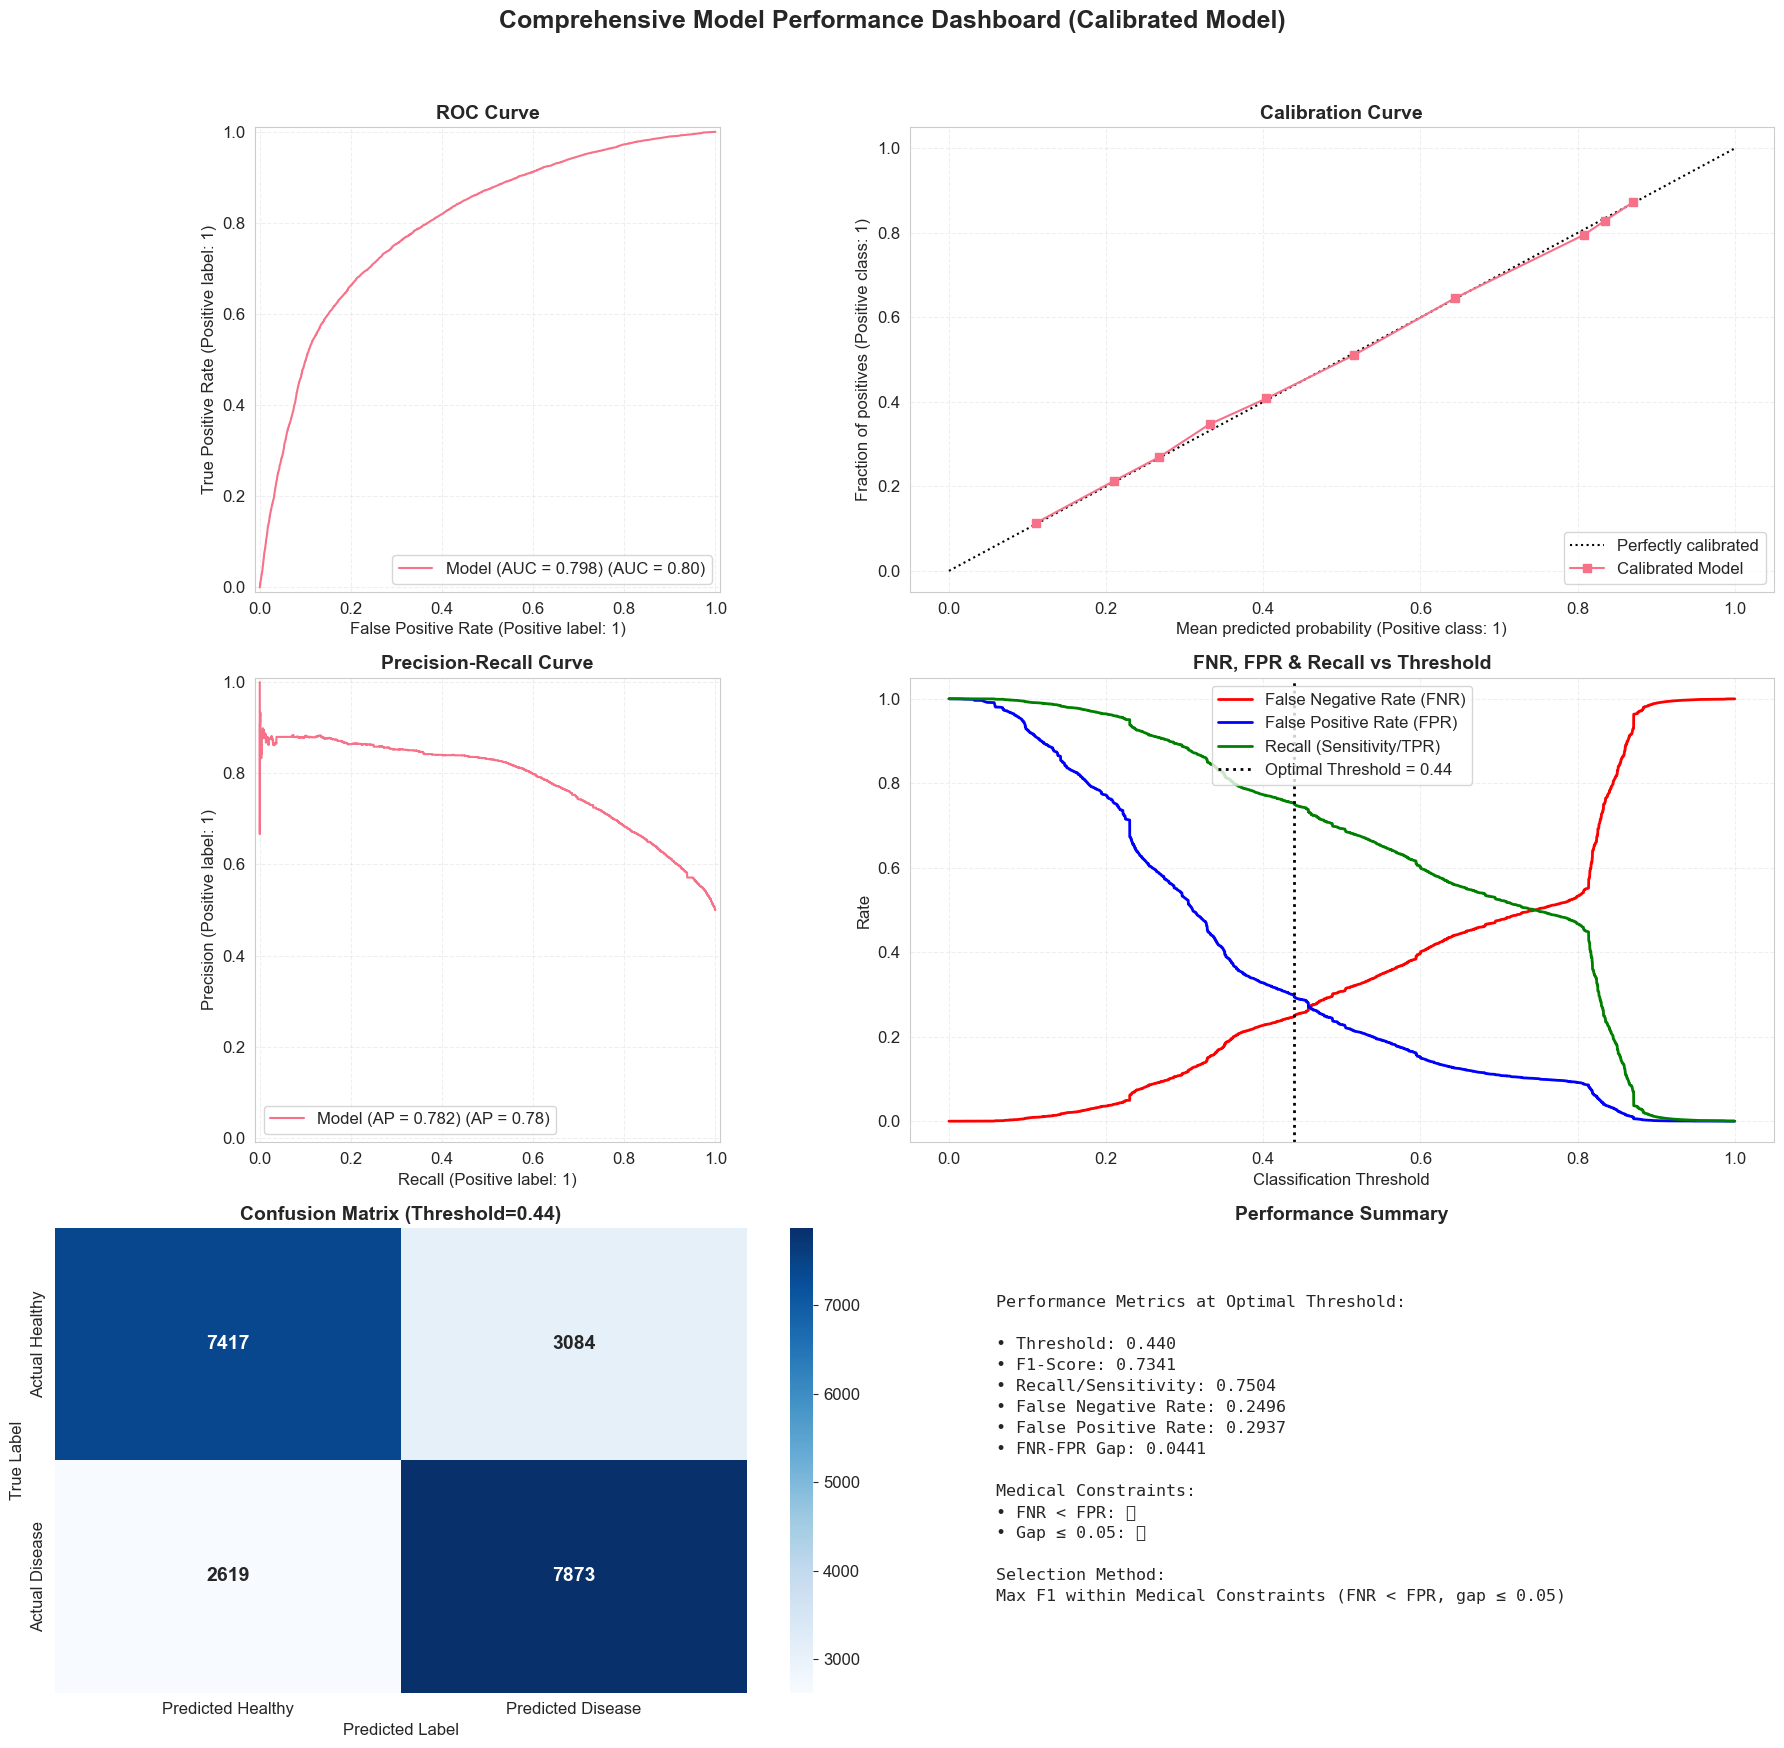


📊 DETAILED PERFORMANCE METRICS:
   Optimal Threshold: 0.440
   F1-Score: 0.7341
   Recall/Sensitivity: 0.7504
   False Negative Rate: 0.2496
   False Positive Rate: 0.2937
   FNR-FPR Gap: 0.0441
   Selection Method: Max F1 within Medical Constraints (FNR < FPR, gap ≤ 0.05)
   Medical Constraints Met: True
   Dashboard saved as single file: P:\projects\heart_disease_prediction\reports\modeling\figures\01_performance_dashboard.png


In [15]:
# ==========================================================
# PERFORMANCE DASHBOARD WITH MEDICAL CONSTRAINTS
# ==========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from sklearn.metrics import (
    roc_curve, precision_recall_curve, roc_auc_score, average_precision_score, 
    confusion_matrix, classification_report, RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.calibration import CalibrationDisplay

# ==========================================================
# Define reports folder and handle existing images
# ==========================================================
current_dir = Path().resolve()
if "src" in [p.name.lower() for p in current_dir.parents]:
    project_root = [p for p in current_dir.parents if p.name.lower() == "src"][0].parent
else:
    project_root = current_dir

REPORTS_DIR = project_root / "reports/modeling/figures"
if not REPORTS_DIR.exists():
    REPORTS_DIR.mkdir(parents=True, exist_ok=True)
    print(f"✅ Created reports directory: {REPORTS_DIR}")

# Remove existing images if they exist
image_files = [
    "01_performance_dashboard.png",
    "02_confusion_matrix.png"
]

for image_file in image_files:
    image_path = REPORTS_DIR / image_file
    if image_path.exists():
        os.remove(file_path)
        print(f"🗑️  Removed existing image: {image_file}")

# ==========================================================
# Predictions using calibrated model
# ==========================================================
y_true = y_test
y_prob = calibrated_model.predict_proba(X_test)[:, 1]

print(f"📊 Predictions generated using calibrated model")
print(f"   Test set size: {len(y_true)}")
print(f"   Positive cases: {y_true.sum()}")
print(f"   Probability range: [{y_prob.min():.3f}, {y_prob.max():.3f}]")

# ==========================================================
# Compute ROC, PR, AUC
# ==========================================================
fpr, tpr, thresholds_roc = roc_curve(y_true, y_prob)
precision, recall, thresholds_pr = precision_recall_curve(y_true, y_prob)
roc_auc = roc_auc_score(y_true, y_prob)
avg_precision = average_precision_score(y_true, y_prob)

print(f"📈 Model Performance:")
print(f"   ROC AUC: {roc_auc:.4f}")
print(f"   Average Precision: {avg_precision:.4f}")

# ==========================================================
# Compute F1 Scores
# ==========================================================
fnr = 1 - tpr
p = y_true.sum()
n = len(y_true) - p
tp = tpr * p
fp = fpr * n

f1_scores = np.divide(
    2 * tp, (2 * tp + fp + (p - tp)), out=np.zeros_like(tp), where=(2 * tp + fp + (p - tp)) > 0
)

# ==========================================================
# Custom Medical Constraints Logic: FNR < FPR and gap ≤ 0.05
# ==========================================================
gap = np.abs(fnr - fpr)
feasible_mask = (fnr < fpr) & (gap <= 0.05)

if np.any(feasible_mask):
    # Apply custom logic: find threshold where FNR < FPR and gap is reasonable
    f1_feasible = f1_scores[feasible_mask]
    best_idx_in_feasible = np.argmax(f1_feasible)
    original_indices = np.where(feasible_mask)[0]
    optimal_idx = original_indices[best_idx_in_feasible]
    selection_method = "Max F1 within Medical Constraints (FNR < FPR, gap ≤ 0.05)"
    print(f"✅ Medical constraints satisfied: {np.sum(feasible_mask)} thresholds meet criteria")
else:
    # Fallback: if no thresholds meet medical constraints, use global max F1
    optimal_idx = np.argmax(f1_scores)
    selection_method = "Fallback (Global Max F1-Score)"
    print("⚠️ No thresholds meet medical constraints, using global max F1")
    
best_threshold = thresholds_roc[optimal_idx]
metrics_at_best = {
    'f1': f1_scores[optimal_idx],
    'fnr': fnr[optimal_idx],
    'fpr': fpr[optimal_idx],
    'tpr': tpr[optimal_idx],
    'recall': tpr[optimal_idx],
    'gap': gap[optimal_idx]
}

print(f"🎯 Optimal threshold found: {best_threshold:.3f} ({selection_method})")

# ==========================================================
# Predictions at optimal threshold for confusion matrix and classification report
# ==========================================================
y_pred_best = (y_prob >= best_threshold).astype(int)
cm = confusion_matrix(y_true, y_pred_best)

# ==========================================================
# Print Classification Report (Only Print - No Save, No Dashboard)
# ==========================================================
print(f"\n📋 CLASSIFICATION REPORT (Threshold = {best_threshold:.3f}):")
print("=" * 60)
cr = classification_report(y_true, y_pred_best, target_names=['Healthy', 'Heart Disease'])
print(cr)
print("=" * 60)

# ==========================================================
# Enhanced Dashboard with Confusion Matrix (3x2 layout)
# ==========================================================
fig, axes = plt.subplots(3, 2, figsize=(18, 18))
axes = axes.ravel()

# ROC Curve
RocCurveDisplay.from_predictions(y_true, y_prob, name=f"Model (AUC = {roc_auc:.3f})", ax=axes[0])
axes[0].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Calibration Curve
CalibrationDisplay.from_predictions(y_true, y_prob, n_bins=10, strategy='quantile', 
                                   name='Calibrated Model', ax=axes[1])
axes[1].set_title('Calibration Curve', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# PR Curve
PrecisionRecallDisplay.from_predictions(y_true, y_prob, name=f"Model (AP = {avg_precision:.3f})", ax=axes[2])
axes[2].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)

# FNR, FPR, Recall vs Threshold
axes[3].plot(thresholds_roc, fnr, label='False Negative Rate (FNR)', lw=2, color='red')
axes[3].plot(thresholds_roc, fpr, label='False Positive Rate (FPR)', lw=2, color='blue')
axes[3].plot(thresholds_roc, tpr, label='Recall (Sensitivity/TPR)', lw=2, color='green')
axes[3].axvline(best_threshold, color='black', linestyle=':', lw=2, 
                label=f'Optimal Threshold = {best_threshold:.2f}')
axes[3].set_title('FNR, FPR & Recall vs Threshold', fontsize=14, fontweight='bold')
axes[3].set_xlabel('Classification Threshold')
axes[3].set_ylabel('Rate')
axes[3].legend()
axes[3].grid(True, alpha=0.3)

# Confusion Matrix (Position 4)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Predicted Healthy', 'Predicted Disease'], 
            yticklabels=['Actual Healthy', 'Actual Disease'],
            annot_kws={"size": 14, "weight": "bold"}, ax=axes[4])
axes[4].set_title(f'Confusion Matrix (Threshold={best_threshold:.2f})', fontsize=14, fontweight='bold')
axes[4].set_xlabel('Predicted Label')
axes[4].set_ylabel('True Label')

# Performance Metrics Summary (Position 5)
metrics_text = f"""
Performance Metrics at Optimal Threshold:

• Threshold: {best_threshold:.3f}
• F1-Score: {metrics_at_best['f1']:.4f}
• Recall/Sensitivity: {metrics_at_best['recall']:.4f}
• False Negative Rate: {metrics_at_best['fnr']:.4f}
• False Positive Rate: {metrics_at_best['fpr']:.4f}
• FNR-FPR Gap: {metrics_at_best['gap']:.4f}

Medical Constraints:
• FNR < FPR: {'✅' if metrics_at_best['fnr'] < metrics_at_best['fpr'] else '❌'}
• Gap ≤ 0.05: {'✅' if metrics_at_best['gap'] <= 0.05 else '❌'}

Selection Method:
{selection_method}
"""

axes[5].text(0.1, 0.9, metrics_text, transform=axes[5].transAxes, fontsize=12, 
             verticalalignment='top', fontfamily='monospace', linespacing=1.5)
axes[5].set_title('Performance Summary', fontsize=14, fontweight='bold')
axes[5].set_xticks([])
axes[5].set_yticks([])
axes[5].spines['top'].set_visible(False)
axes[5].spines['right'].set_visible(False)
axes[5].spines['bottom'].set_visible(False)
axes[5].spines['left'].set_visible(False)

plt.suptitle('Comprehensive Model Performance Dashboard (Calibrated Model)', fontsize=18, fontweight='bold', y=0.97)
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save performance dashboard (single file)
dashboard_path = REPORTS_DIR / "01_performance_dashboard.png"
fig.savefig(dashboard_path, dpi=150, bbox_inches='tight', facecolor='white')
print(f"💾 Saved comprehensive performance dashboard: {dashboard_path}")
plt.show()

# ==========================================================
# Print detailed performance metrics
# ==========================================================
print(f"\n📊 DETAILED PERFORMANCE METRICS:")
print(f"   Optimal Threshold: {best_threshold:.3f}")
print(f"   F1-Score: {metrics_at_best['f1']:.4f}")
print(f"   Recall/Sensitivity: {metrics_at_best['recall']:.4f}")
print(f"   False Negative Rate: {metrics_at_best['fnr']:.4f}")
print(f"   False Positive Rate: {metrics_at_best['fpr']:.4f}")
print(f"   FNR-FPR Gap: {metrics_at_best['gap']:.4f}")
print(f"   Selection Method: {selection_method}")
print(f"   Medical Constraints Met: {np.any(feasible_mask)}")
print(f"   Dashboard saved as single file: {dashboard_path}")

📁 Using visual directory: P:\projects\heart_disease_prediction\reports\modeling\figures
✅ Data validation passed:
   Training set: (48983, 16) samples, 24480.0 positive cases
   Test set: (20993, 16) samples, 10492.0 positive cases
   Calibrated model type: <class 'sklearn.calibration.CalibratedClassifierCV'>

STEP 1: GENERATING RISK SCORES ON TRAINING SET
✅ Training set risk scores generated:
   CHDRI Score range: 0.000 - 1.000

📊 TRAINING SET RISK GROUP DISTRIBUTION:
   Low Risk: 1979 patients (4.0%)
   Medium Risk: 9239 patients (18.9%)
   High Risk: 15097 patients (30.8%)
   Very High Risk: 22668 patients (46.3%)

STEP 2: GENERATING RISK SCORES ON TEST SET
✅ Test set risk scores generated:
   CHDRI Score range: 0.000 - 1.000

📊 TEST SET RISK GROUP DISTRIBUTION:
   Low Risk: 845 patients (4.0%)
   Medium Risk: 4028 patients (19.2%)
   High Risk: 6451 patients (30.7%)
   Very High Risk: 9669 patients (46.1%)

STEP 3: EVENT RATES BY RISK GROUP

📈 EVENT RATES BY RISK GROUP:
    Dataset

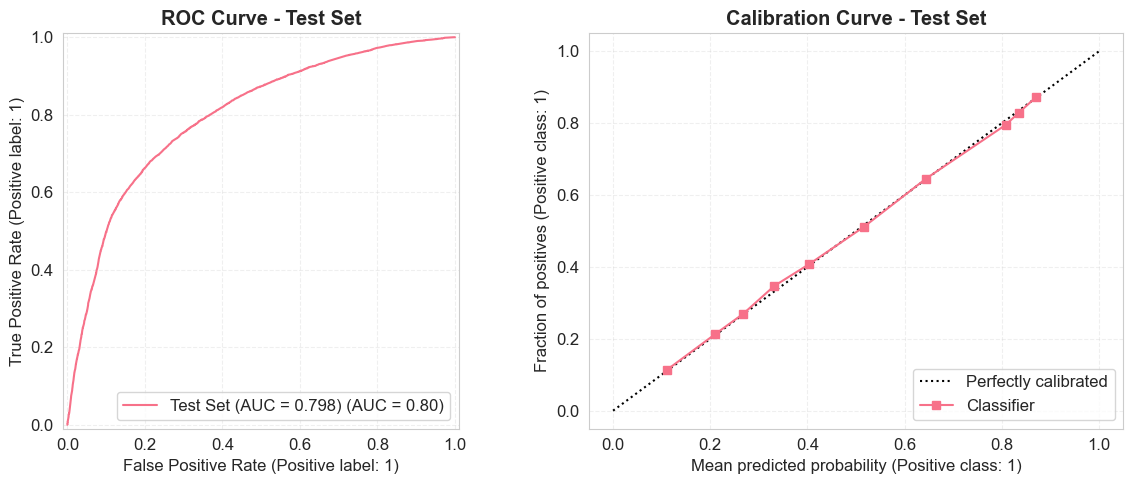

📊 Creating Risk Score Distributions...
💾 Saved: 03_risk_score_distributions.png


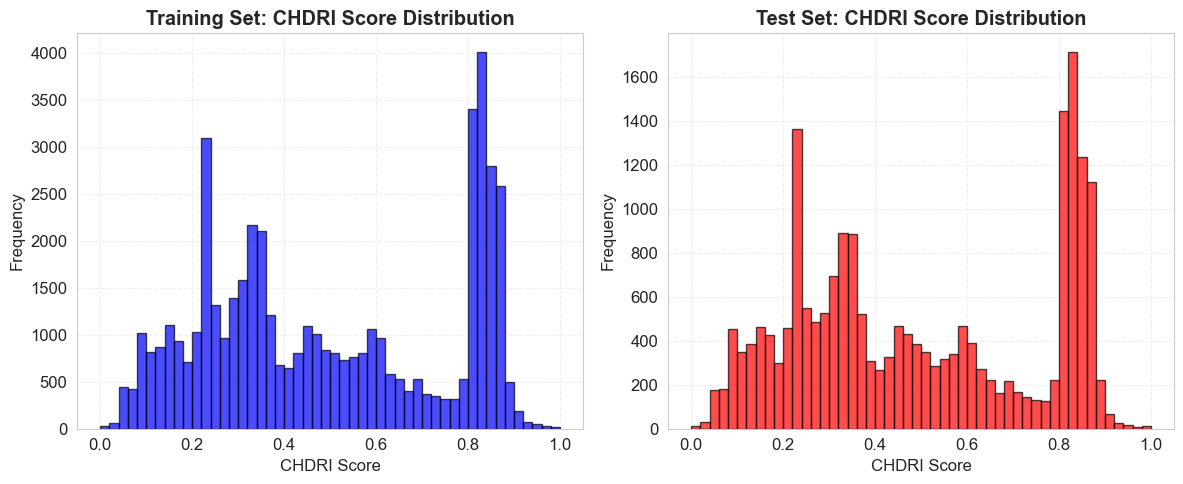

📋 Creating Risk Group Distribution Comparison...
💾 Saved: 04_risk_group_distribution_comparison.png


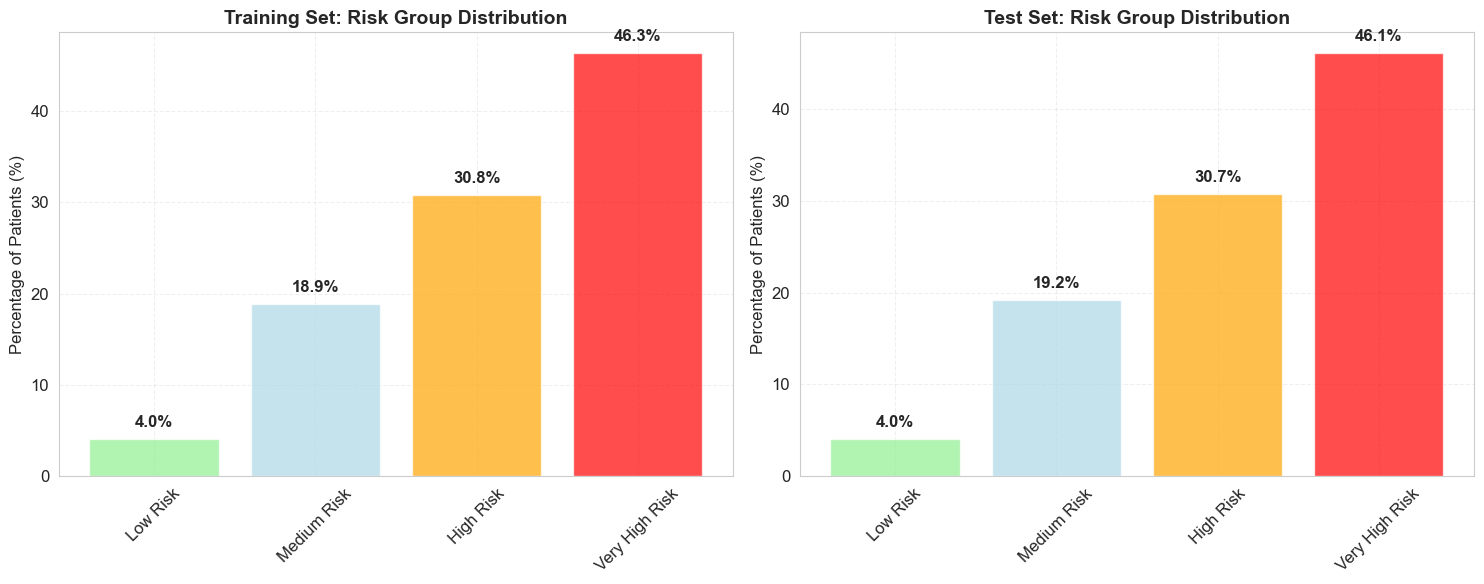

🎯 Creating Event Rates by Risk Group...
💾 Saved: 05_risk_event_rates_comparison.png


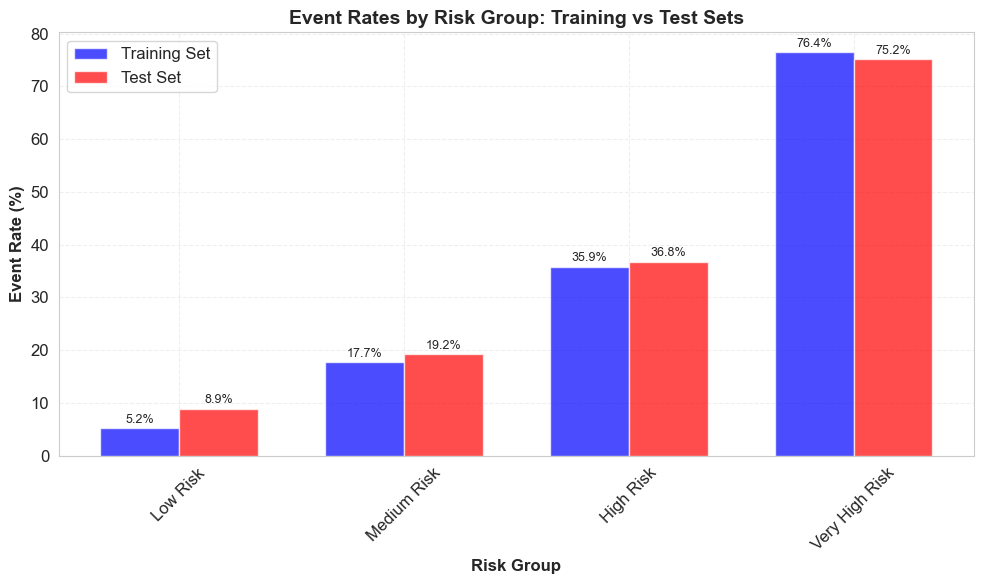

In [16]:
# ==========================================================
# COMPLETE RISK SCORE DEVELOPMENT & EVALUATION PIPELINE
# ==========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve
from sklearn.calibration import CalibrationDisplay

# Set up directories
current_dir = Path().resolve()
project_root = current_dir

# Look for project root by checking common parent directories
for parent in current_dir.parents:
    if (parent / "reports").exists():
        project_root = parent
        break

# Create output directory
visual_dir = project_root / "reports" / "modeling" / "figures"
visual_dir.mkdir(parents=True, exist_ok=True)

# Remove existing risk analysis images
risk_image_files = [
    "02_roc_calibration_curves.png",
    "03_risk_score_distributions.png",
    "04_risk_group_distribution_comparison.png",
    "05_risk_event_rates_comparison.png"
]

for image_file in risk_image_files:
    image_path = visual_dir / image_file
    if image_path.exists():
        os.remove(image_path)
        print(f"🗑️  Removed existing image: {image_file}")

print(f"📁 Using visual directory: {visual_dir.resolve()}")

# -----------------------------
# Data Validation
# -----------------------------
# Check if required data exists
required_vars = ['X_train', 'X_test', 'y_train', 'y_test', 'calibrated_model']
missing_vars = [var for var in required_vars if var not in locals() and var not in globals()]
if missing_vars:
    raise NameError(f"❌ Missing required variables: {missing_vars}")

print(f"✅ Data validation passed:")
print(f"   Training set: {X_train.shape} samples, {y_train.sum()} positive cases")
print(f"   Test set: {X_test.shape} samples, {y_test.sum()} positive cases")
print(f"   Calibrated model type: {type(calibrated_model)}")

# -----------------------------
# Create Risk Groups Function
# -----------------------------
def create_risk_groups(risk_scores):
    """Create clinically meaningful risk groups"""
    conditions = [
        risk_scores < 0.1,   # Low Risk
        risk_scores < 0.25,  # Medium Risk
        risk_scores < 0.5,   # High Risk
        risk_scores >= 0.5   # Very High Risk
    ]
    choices = ['Low Risk', 'Medium Risk', 'High Risk', 'Very High Risk']
    return np.select(conditions, choices, default='Medium Risk')

# -----------------------------
# STEP 1: Generate Risk Scores on Training Set
# -----------------------------
print("\n" + "="*50)
print("STEP 1: GENERATING RISK SCORES ON TRAINING SET")
print("="*50)

# Create training set with risk scores
X_train_risk = X_train.copy()
X_train_risk['CHDRI_Score'] = calibrated_model.predict_proba(X_train)[:, 1]
X_train_risk['Risk_Group'] = create_risk_groups(X_train_risk['CHDRI_Score'])
X_train_risk['True_Label'] = y_train.values

print("✅ Training set risk scores generated:")
print(f"   CHDRI Score range: {X_train_risk['CHDRI_Score'].min():.3f} - {X_train_risk['CHDRI_Score'].max():.3f}")

# Training set risk group distribution
risk_order = ['Low Risk', 'Medium Risk', 'High Risk', 'Very High Risk']
train_risk_counts = X_train_risk['Risk_Group'].value_counts().reindex(risk_order, fill_value=0)

print("\n📊 TRAINING SET RISK GROUP DISTRIBUTION:")
total_train = len(X_train_risk)
for group in risk_order:
    count = train_risk_counts[group]
    percentage = (count / total_train) * 100
    print(f"   {group}: {count} patients ({percentage:.1f}%)")

# -----------------------------
# STEP 2: Generate Risk Scores on Test Set
# -----------------------------
print("\n" + "="*50)
print("STEP 2: GENERATING RISK SCORES ON TEST SET")
print("="*50)

# Create test set with risk scores
X_test_risk = X_test.copy()
X_test_risk['CHDRI_Score'] = calibrated_model.predict_proba(X_test)[:, 1]
X_test_risk['Risk_Group'] = create_risk_groups(X_test_risk['CHDRI_Score'])
X_test_risk['True_Label'] = y_test.values

print("✅ Test set risk scores generated:")
print(f"   CHDRI Score range: {X_test_risk['CHDRI_Score'].min():.3f} - {X_test_risk['CHDRI_Score'].max():.3f}")

# Test set risk group distribution
test_risk_counts = X_test_risk['Risk_Group'].value_counts().reindex(risk_order, fill_value=0)

print("\n📊 TEST SET RISK GROUP DISTRIBUTION:")
total_test = len(X_test_risk)
for group in risk_order:
    count = test_risk_counts[group]
    percentage = (count / total_test) * 100
    print(f"   {group}: {count} patients ({percentage:.1f}%)")

# -----------------------------
# STEP 3: Calculate Event Rates by Risk Group
# -----------------------------
print("\n" + "="*50)
print("STEP 3: EVENT RATES BY RISK GROUP")
print("="*50)

def calculate_event_rates(risk_df, dataset_name):
    """Calculate event rates for each risk group"""
    event_rates = []
    for group in risk_order:
        group_data = risk_df[risk_df['Risk_Group'] == group]
        if len(group_data) > 0:
            events = group_data['True_Label'].sum()
            total = len(group_data)
            event_rate = events / total if total > 0 else 0
            event_rates.append({
                'Dataset': dataset_name,
                'Risk_Group': group,
                'Total_Patients': total,
                'Events': events,
                'Event_Rate': event_rate
            })
    return pd.DataFrame(event_rates)

# Calculate for both datasets
train_events = calculate_event_rates(X_train_risk, 'Training')
test_events = calculate_event_rates(X_test_risk, 'Test')
event_rates_df = pd.concat([train_events, test_events], ignore_index=True)

print("\n📈 EVENT RATES BY RISK GROUP:")
print(event_rates_df.round(3))

# -----------------------------
# STEP 4: Performance Evaluation on Test Set
# -----------------------------
print("\n" + "="*50)
print("STEP 4: MODEL PERFORMANCE EVALUATION ON TEST SET")
print("="*50)

# Get predictions for performance metrics
y_true_test = X_test_risk['True_Label']
y_prob_test = X_test_risk['CHDRI_Score']

# Calculate performance metrics
roc_auc = roc_auc_score(y_true_test, y_prob_test)
avg_precision = average_precision_score(y_true_test, y_prob_test)

print(f"📊 TEST SET PERFORMANCE METRICS:")
print(f"   ROC AUC: {roc_auc:.4f}")
print(f"   Average Precision: {avg_precision:.4f}")

# -----------------------------
# STEP 5: Create Comprehensive Visualizations (CORRECTED ORDER)
# -----------------------------
print("\n" + "="*50)
print("STEP 5: CREATING COMPREHENSIVE VISUALIZATIONS")
print("="*50)

# 5.1 ROC and Calibration Curves (FIRST)
print("📈 Creating ROC and Calibration Curves...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# ROC Curve
RocCurveDisplay.from_predictions(y_true_test, y_prob_test, ax=ax1, name=f'Test Set (AUC = {roc_auc:.3f})')
ax1.set_title('ROC Curve - Test Set', fontweight='bold')
ax1.grid(alpha=0.3)

# Calibration Curve
CalibrationDisplay.from_predictions(y_true_test, y_prob_test, n_bins=10, strategy='quantile', ax=ax2)
ax2.set_title('Calibration Curve - Test Set', fontweight='bold')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(visual_dir / '02_roc_calibration_curves.png', dpi=300, bbox_inches='tight')
print(f"💾 Saved: 02_roc_calibration_curves.png")
plt.show()

# 5.2 Risk Score Distribution (SECOND)
print("📊 Creating Risk Score Distributions...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Training set distribution
ax1.hist(X_train_risk['CHDRI_Score'], bins=50, alpha=0.7, color='blue', edgecolor='black')
ax1.set_xlabel('CHDRI Score')
ax1.set_ylabel('Frequency')
ax1.set_title('Training Set: CHDRI Score Distribution', fontweight='bold')
ax1.grid(alpha=0.3)

# Test set distribution
ax2.hist(X_test_risk['CHDRI_Score'], bins=50, alpha=0.7, color='red', edgecolor='black')
ax2.set_xlabel('CHDRI Score')
ax2.set_ylabel('Frequency')
ax2.set_title('Test Set: CHDRI Score Distribution', fontweight='bold')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(visual_dir / '03_risk_score_distributions.png', dpi=300, bbox_inches='tight')
print(f"💾 Saved: 03_risk_score_distributions.png")
plt.show()

# 5.3 Risk Group Distribution Comparison (THIRD)
print("📋 Creating Risk Group Distribution Comparison...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Training set distribution
train_percentages = [train_risk_counts[group] / total_train * 100 for group in risk_order]
bars1 = ax1.bar(risk_order, train_percentages, color=['lightgreen', 'lightblue', 'orange', 'red'], alpha=0.7)
ax1.set_title('Training Set: Risk Group Distribution', fontsize=14, fontweight='bold')
ax1.set_ylabel('Percentage of Patients (%)')
ax1.tick_params(axis='x', rotation=45)
for bar, percentage in zip(bars1, train_percentages):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{percentage:.1f}%', ha='center', va='bottom', fontweight='bold')

# Test set distribution
test_percentages = [test_risk_counts[group] / total_test * 100 for group in risk_order]
bars2 = ax2.bar(risk_order, test_percentages, color=['lightgreen', 'lightblue', 'orange', 'red'], alpha=0.7)
ax2.set_title('Test Set: Risk Group Distribution', fontsize=14, fontweight='bold')
ax2.set_ylabel('Percentage of Patients (%)')
ax2.tick_params(axis='x', rotation=45)
for bar, percentage in zip(bars2, test_percentages):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{percentage:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(visual_dir / '04_risk_group_distribution_comparison.png', dpi=300, bbox_inches='tight')
print(f"💾 Saved: 04_risk_group_distribution_comparison.png")
plt.show()

# 5.4 Event Rates by Risk Group (FOURTH)
print("🎯 Creating Event Rates by Risk Group...")
fig, ax = plt.subplots(figsize=(10, 6))
x_pos = np.arange(len(risk_order))
width = 0.35

train_rates = event_rates_df[event_rates_df['Dataset'] == 'Training']['Event_Rate'].values
test_rates = event_rates_df[event_rates_df['Dataset'] == 'Test']['Event_Rate'].values

bars1 = ax.bar(x_pos - width/2, train_rates * 100, width, label='Training Set', alpha=0.7, color='blue')
bars2 = ax.bar(x_pos + width/2, test_rates * 100, width, label='Test Set', alpha=0.7, color='red')

ax.set_xlabel('Risk Group', fontsize=12, fontweight='bold')
ax.set_ylabel('Event Rate (%)', fontsize=12, fontweight='bold')
ax.set_title('Event Rates by Risk Group: Training vs Test Sets', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(risk_order, rotation=45)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(visual_dir / '05_risk_event_rates_comparison.png', dpi=300, bbox_inches='tight')
print(f"💾 Saved: 05_risk_event_rates_comparison.png")
plt.show()

📁 Using visual directory: P:\projects\heart_disease_prediction\reports\modeling\figures
📊 Using 4000 samples for SHAP analysis.


 98%|===================| 3933/4000 [00:29<00:00]        

💾 Saved: 06_shap_probability_plot.png


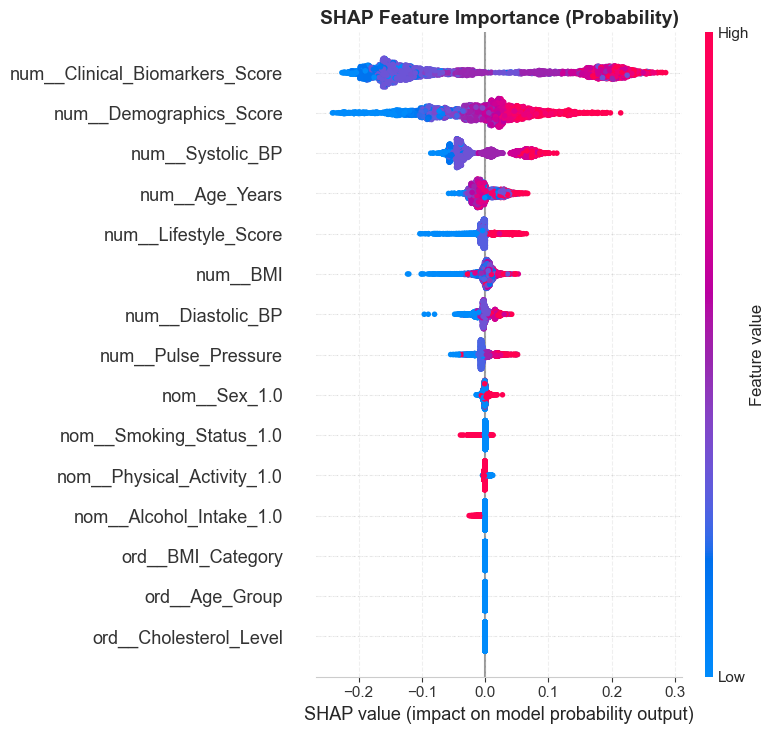

✅ SHAP probability plot completed!


In [17]:
# -----------------------------
# Set up directories - CORRECT LOGICAL PATH
# -----------------------------
import shap
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os

current_dir = Path().resolve()
project_root = current_dir

# Look for project root by checking common parent directories
for parent in current_dir.parents:
    if (parent / "reports").exists():
        project_root = parent
        break

visual_dir = project_root / "reports" / "modeling" / "figures"
visual_dir.mkdir(parents=True, exist_ok=True)

# Remove existing SHAP image if present
shap_image_file = "07_shap_probability_plot.png"
shap_image_path = visual_dir / shap_image_file
if shap_image_path.exists():
    os.remove(shap_image_path)
    print(f"🗑️  Removed existing image: {shap_image_file}")

print(f"📁 Using visual directory: {visual_dir.resolve()}")

# 1. Transform the test data using your fitted preprocessor
X_test_processed = preprocessor.transform(X_test)
if hasattr(X_test_processed, 'toarray'):
    X_test_processed = X_test_processed.toarray()

# 2. Get the correct feature names after preprocessing
feature_names = list(preprocessor.get_feature_names_out())

# 3. Create a DataFrame from the processed data for SHAP analysis
# Using a sample is efficient for plotting
X_sample = pd.DataFrame(X_test_processed[:4000], columns=feature_names)
print(f"📊 Using {len(X_sample)} samples for SHAP analysis.")

# 4. Extract the actual trained model from the calibrated pipeline
# The internal fitted model is stored in the .estimator attribute
actual_model = calibrated_model.calibrated_classifiers_[0].estimator.named_steps['model']

# 5. Use shap.TreeExplainer and set model_output='probability'
# This is the key step to explain the final probability (0-1) instead of the raw margin.
explainer = shap.TreeExplainer(actual_model, X_sample, model_output="probability")
# For this model, this call returns a single matrix of shap values for the positive class.
shap_values = explainer.shap_values(X_sample)

# 6. Create the swarm plot
plt.figure(figsize=(12, 8))

# Pass the entire shap_values matrix directly to the plot function.
# This resolves the error as it provides the expected 2D array (samples x features).
shap.summary_plot(shap_values, X_sample, plot_type="dot",
                  show=False, max_display=15)

plt.title("SHAP Feature Importance (Probability)", fontsize=14, fontweight='bold')
plt.xlabel("SHAP value (impact on model probability output)")
plt.tight_layout()

# 7. Save the plot
plt.savefig(visual_dir / '06_shap_probability_plot.png', dpi=300, bbox_inches='tight', facecolor='white')
print(f"💾 Saved: 06_shap_probability_plot.png")
plt.show()

print("✅ SHAP probability plot completed!")

📁 Using visual directory: P:\projects\heart_disease_prediction\reports\modeling\figures

📈 COMPOSITE SCORES BY RISK GROUP:
       Risk_Group  Demographics_Score  Clinical_Biomarkers_Score  \
0        Low Risk             -1.3180                    -0.5810   
1     Medium Risk             -0.7100                    -0.3390   
2       High Risk              0.0040                    -0.0750   
3  Very High Risk              0.2830                     1.0140   

   Lifestyle_Score  
0           0.0020  
1           0.0040  
2           0.0140  
3           0.0150  
💾 Saved: 07_composite_scores_trends_in_risk_groups.png


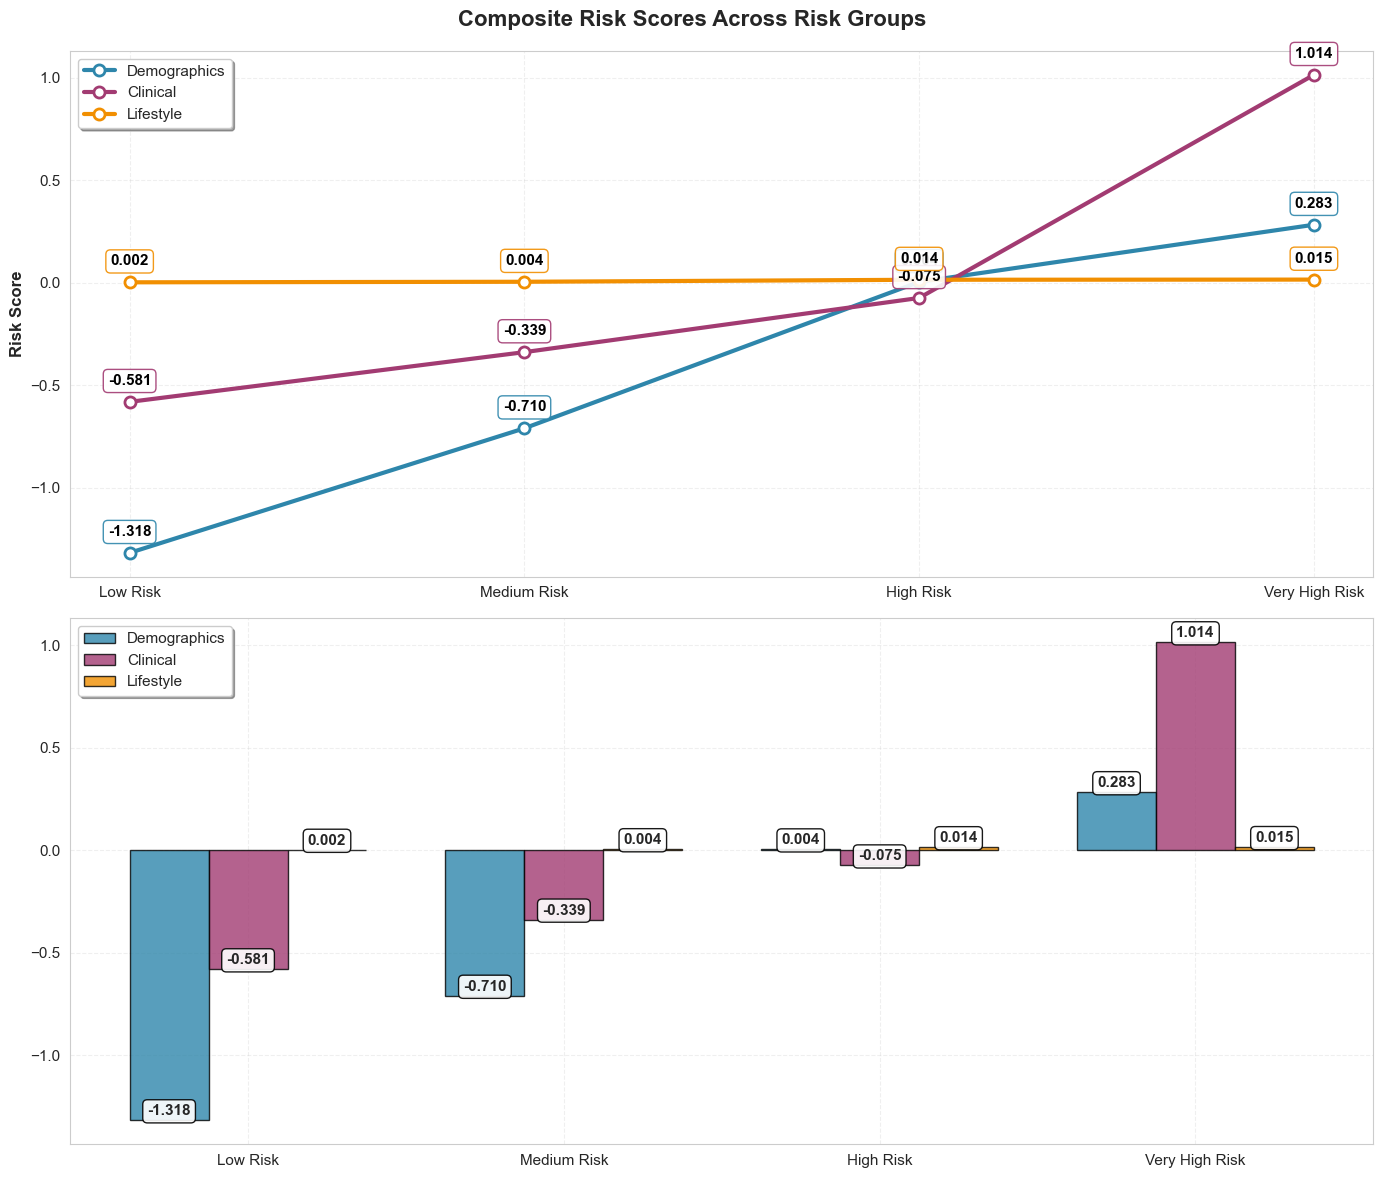

In [18]:
# ==========================================================
# COMPOSITE SCORES TREND ANALYSIS - CLEAN LAYOUT
# ==========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os

# Set up directories
current_dir = Path().resolve()
project_root = current_dir

for parent in current_dir.parents:
    if (parent / "reports").exists():
        project_root = parent
        break

visual_dir = project_root / "reports" / "modeling" / "figures"
visual_dir.mkdir(parents=True, exist_ok=True)

# Remove existing composite scores image
composite_image_file = "07_composite_scores_trends_in_risk_groups.png"
composite_image_path = visual_dir / composite_image_file
if composite_image_path.exists():
    os.remove(composite_image_path)
    print(f"🗑️  Removed existing image: {composite_image_file}")

print(f"📁 Using visual directory: {visual_dir.resolve()}")

# -----------------------------
# Prepare data
# -----------------------------
composite_cols = ['Demographics_Score', 'Clinical_Biomarkers_Score', 'Lifestyle_Score']

# Create risk data if not exists
if 'X_test_risk' not in locals():
    X_test_risk = X_test.copy()
    X_test_risk['CHDRI_Score'] = calibrated_model.predict_proba(X_test)[:, 1]
    X_test_risk['Risk_Group'] = create_risk_groups(X_test_risk['CHDRI_Score'])

# Calculate mean scores by risk group
risk_order = ['Low Risk', 'Medium Risk', 'High Risk', 'Very High Risk']
risk_group_scores = (
    X_test_risk.groupby('Risk_Group')[composite_cols]
    .mean()
    .reindex(risk_order)
    .reset_index()
)

print("\n📈 COMPOSITE SCORES BY RISK GROUP:")
print(risk_group_scores.round(3))

# -----------------------------
# Create vertical subplots
# -----------------------------
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# Colors and labels
colors = ['#2E86AB', '#A23B72', '#F18F01']
labels = ['Demographics', 'Clinical', 'Lifestyle']  # Simplified names

# TOP PLOT: Line Chart
for i, col in enumerate(composite_cols):
    line = ax1.plot(risk_group_scores['Risk_Group'], risk_group_scores[col], 
                    marker='o', linewidth=3, markersize=8, color=colors[i], 
                    label=labels[i], markerfacecolor='white', markeredgewidth=2)
    
    # Value annotations on line points
    for j, value in enumerate(risk_group_scores[col]):
        ax1.annotate(f'{value:.3f}', 
                    xy=(j, value), 
                    xytext=(0, 10),
                    textcoords='offset points',
                    ha='center', va='bottom',
                    fontsize=11, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9, 
                             edgecolor=colors[i], linewidth=1),
                    color='black')

ax1.set_ylabel('Risk Score', fontweight='bold', fontsize=12)
ax1.legend(fontsize=11, frameon=True, fancybox=True, shadow=True, loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', labelsize=11)
ax1.tick_params(axis='y', labelsize=11)

# BOTTOM PLOT: Bar Chart
x_pos = np.arange(len(risk_group_scores))
width = 0.25

for i, col in enumerate(composite_cols):
    bars = ax2.bar(x_pos + i*width, risk_group_scores[col], width, 
                   color=colors[i], label=labels[i], alpha=0.8, 
                   edgecolor='black', linewidth=1)
    
    # Value annotations on bars
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', 
                ha='center', va='bottom',
                fontsize=11, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9, 
                         edgecolor='black'))

ax2.set_xticks(x_pos + width)
ax2.set_xticklabels(risk_group_scores['Risk_Group'], fontsize=11)  # Horizontal labels
ax2.legend(fontsize=11, frameon=True, fancybox=True, shadow=True, loc='upper left')
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='y', labelsize=11)

# SINGLE MAIN TITLE
plt.suptitle('Composite Risk Scores Across Risk Groups', fontsize=16, fontweight='bold', y=0.98)

# -----------------------------
# Save and show
# -----------------------------
plt.tight_layout()
plt.savefig(visual_dir / '07_composite_scores_trends_in_risk_groups.png', dpi=300, bbox_inches='tight', facecolor='white')
print(f"💾 Saved: 07_composite_scores_trends_in_risk_groups.png")
plt.show()

📁 Using visual directory: P:\projects\heart_disease_prediction\reports\modeling\figures
📊 Found 16 total processed features
📊 Using 13 non-score features for analysis
   • Numerical features: 5
   • Ordinal features: 4
   • Nominal features: 4

📊 Analyzing trends for 13 features:
   • num__Age_Years (Numerical)
   • num__Systolic_BP (Numerical)
   • num__Diastolic_BP (Numerical)
   • num__BMI (Numerical)
   • num__Pulse_Pressure (Numerical)
   • ord__Glucose_Level (Ordinal)
   • ord__Cholesterol_Level (Ordinal)
   • ord__Age_Group (Ordinal)
   • ord__BMI_Category (Ordinal)
   • nom__Sex_1.0 (Nominal)
   • nom__Smoking_Status_1.0 (Nominal)
   • nom__Alcohol_Intake_1.0 (Nominal)
   • nom__Physical_Activity_1.0 (Nominal)

📈 PROCESSED FEATURE TRENDS BY RISK GROUP:
       Risk_Group  num__Age_Years  num__Systolic_BP  num__Diastolic_BP  \
0        Low Risk         -1.2090           -0.5593            -0.7844   
1     Medium Risk         -0.6735           -0.3245            -0.4997   
2      

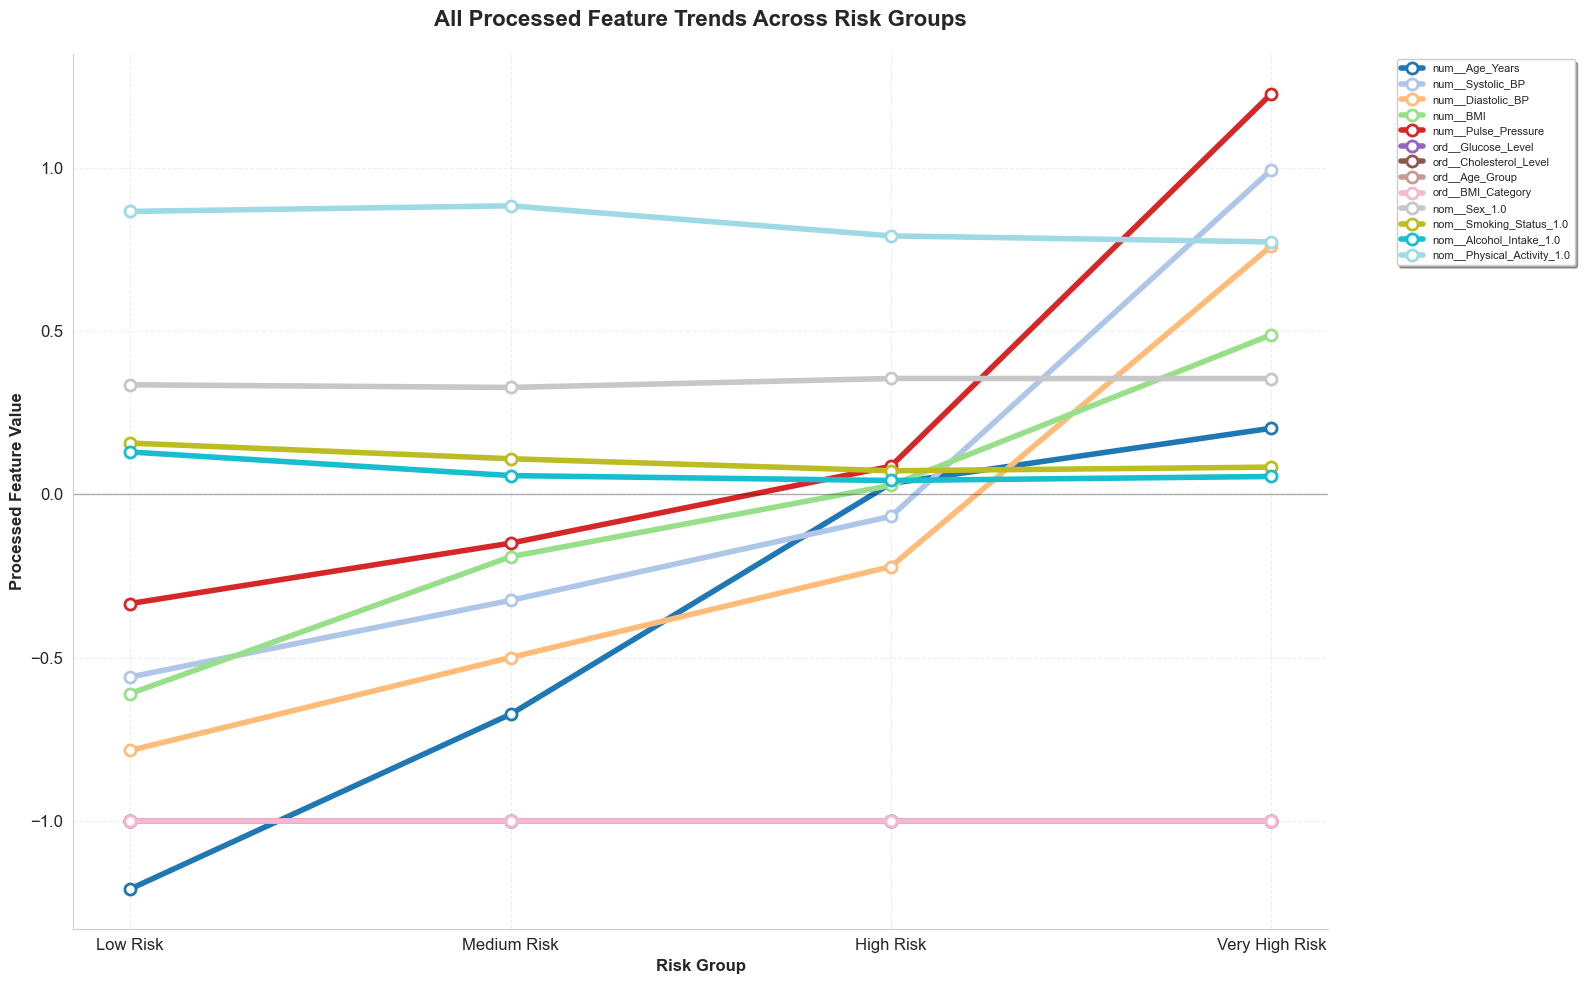


📊 FEATURE STATISTICS TABLE:

FEATURE STATISTICS SUMMARY
                   Feature      Type     Min     Max    Mean    Std              Range
            num__Age_Years Numerical -2.4000  1.1000 -0.0741 0.6789  -2.4000 to 1.1000
          num__Systolic_BP Numerical -2.5000  6.0000  0.3528 0.8638  -2.5000 to 6.0000
         num__Diastolic_BP Numerical -4.0000  7.0000  0.1555 0.9831  -4.0000 to 7.0000
                  num__BMI Numerical -2.1698  6.9586  0.1728 0.8403  -2.1698 to 6.9586
       num__Pulse_Pressure Numerical -4.0000 10.0000  0.5502 1.1823 -4.0000 to 10.0000
        ord__Glucose_Level   Ordinal -1.0000 -1.0000 -1.0000 0.0000 -1.0000 to -1.0000
    ord__Cholesterol_Level   Ordinal -1.0000 -1.0000 -1.0000 0.0000 -1.0000 to -1.0000
            ord__Age_Group   Ordinal -1.0000 -1.0000 -1.0000 0.0000 -1.0000 to -1.0000
         ord__BMI_Category   Ordinal -1.0000 -1.0000 -1.0000 0.0000 -1.0000 to -1.0000
              nom__Sex_1.0   Nominal  0.0000  1.0000  0.3493 0.4767   0.0

In [19]:
# ==========================================================
# FEATURE TRENDS ACROSS RISK GROUPS - ALL PROCESSED FEATURES
# ==========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os

# Set up directories
current_dir = Path().resolve()
project_root = current_dir

for parent in current_dir.parents:
    if (parent / "reports").exists():
        project_root = parent
        break

visual_dir = project_root / "reports" / "modeling" / "figures"
visual_dir.mkdir(parents=True, exist_ok=True)

# Remove existing feature trends image
feature_trends_image_file = "08_feature_trends_risk_groups.png"
feature_trends_image_path = visual_dir / feature_trends_image_file
if feature_trends_image_path.exists():
    os.remove(feature_trends_image_path)
    print(f"🗑️  Removed existing image: {feature_trends_image_file}")

print(f"📁 Using visual directory: {visual_dir.resolve()}")

# -----------------------------
# Prepare data - ALL PROCESSED FEATURE VALUES
# -----------------------------
# Get all processed feature names from the preprocessor
all_processed_features = list(preprocessor.get_feature_names_out())

# Filter out score features (keep only non-score features)
non_score_features = [feature for feature in all_processed_features 
                     if 'Score' not in feature and 'Demographics_Score' not in feature 
                     and 'Clinical_Biomarkers_Score' not in feature and 'Lifestyle_Score' not in feature]

print(f"📊 Found {len(all_processed_features)} total processed features")
print(f"📊 Using {len(non_score_features)} non-score features for analysis")

# Show feature categories
num_features = [f for f in non_score_features if f.startswith('num__')]
ord_features = [f for f in non_score_features if f.startswith('ord__')]
nom_features = [f for f in non_score_features if f.startswith('nom__')]

print(f"   • Numerical features: {len(num_features)}")
print(f"   • Ordinal features: {len(ord_features)}")
print(f"   • Nominal features: {len(nom_features)}")

# Use all non-score features
selected_features = non_score_features

print(f"\n📊 Analyzing trends for {len(selected_features)} features:")
for feature in selected_features:
    feature_type = "Numerical" if feature.startswith('num__') else "Ordinal" if feature.startswith('ord__') else "Nominal"
    print(f"   • {feature} ({feature_type})")

# Transform the test data to get processed values
X_test_processed = preprocessor.transform(X_test)
if hasattr(X_test_processed, 'toarray'):
    X_test_processed = X_test_processed.toarray()

# Create DataFrame with processed features
X_test_processed_df = pd.DataFrame(X_test_processed, columns=all_processed_features)

# Create risk data with processed features
X_test_risk_processed = X_test_processed_df[selected_features].copy()
X_test_risk_processed['CHDRI_Score'] = calibrated_model.predict_proba(X_test)[:, 1]
X_test_risk_processed['Risk_Group'] = create_risk_groups(X_test_risk_processed['CHDRI_Score'])

# Calculate mean processed values by risk group
risk_order = ['Low Risk', 'Medium Risk', 'High Risk', 'Very High Risk']
feature_trends = (
    X_test_risk_processed.groupby('Risk_Group')[selected_features]
    .mean()
    .reindex(risk_order)
    .reset_index()
)

print("\n📈 PROCESSED FEATURE TRENDS BY RISK GROUP:")
print(feature_trends.round(4))

# -----------------------------
# Create clean single trend plot with THICKER LINES
# -----------------------------
plt.figure(figsize=(16, 10))

# Create a distinct color for each feature using a colormap
colors = plt.cm.tab20(np.linspace(0, 1, len(selected_features)))

# Plot all processed features on single chart with THICKER LINES
for feature, color in zip(selected_features, colors):
    plt.plot(feature_trends['Risk_Group'], feature_trends[feature],
             marker='o', linewidth=4.0, markersize=8, color=color,  # Increased linewidth from 2.5 to 4.0
             label=feature,
             markerfacecolor='white', markeredgewidth=2.0)  # Increased markeredgewidth

plt.title('All Processed Feature Trends Across Risk Groups', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Processed Feature Value', fontweight='bold', fontsize=12)
plt.xlabel('Risk Group', fontweight='bold', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, 
           frameon=True, fancybox=True, shadow=True)

plt.grid(True, alpha=0.3)
plt.xticks(rotation=0)

# Allow both positive and negative values (no normalization)
ax = plt.gca()

# Clean spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add zero line for reference
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=1)

# -----------------------------
# Save and show
# -----------------------------
plt.tight_layout()
plt.savefig(visual_dir / '08_feature_trends_risk_groups.png', dpi=300, bbox_inches='tight', facecolor='white')
print(f"💾 Saved: 08_feature_trends_risk_groups.png")
plt.show()

# -----------------------------
# Create statistics in TABLE FORMAT (DataFrame)
# -----------------------------
print(f"\n📊 FEATURE STATISTICS TABLE:")
stats_data = []
for feature in selected_features:
    min_val = X_test_risk_processed[feature].min()
    max_val = X_test_risk_processed[feature].max()
    mean_val = X_test_risk_processed[feature].mean()
    std_val = X_test_risk_processed[feature].std()
    feature_type = "Numerical" if feature.startswith('num__') else "Ordinal" if feature.startswith('ord__') else "Nominal"
    
    stats_data.append({
        'Feature': feature,
        'Type': feature_type,
        'Min': f"{min_val:.4f}",
        'Max': f"{max_val:.4f}",
        'Mean': f"{mean_val:.4f}",
        'Std': f"{std_val:.4f}",
        'Range': f"{min_val:.4f} to {max_val:.4f}"
    })

# Create and display statistics DataFrame
stats_df = pd.DataFrame(stats_data)
print("\n" + "="*80)
print("FEATURE STATISTICS SUMMARY")
print("="*80)
print(stats_df.to_string(index=False))
print("="*80)

# -----------------------------
# Risk group distribution table
# -----------------------------
print(f"\n📊 RISK GROUP DISTRIBUTION TABLE:")
risk_group_data = []
for group in risk_order:
    count = len(X_test_risk_processed[X_test_risk_processed['Risk_Group'] == group])
    percentage = (count / len(X_test_risk_processed)) * 100
    risk_group_data.append({
        'Risk Group': group,
        'Count': count,
        'Percentage': f"{percentage:.1f}%"
    })

risk_group_df = pd.DataFrame(risk_group_data)
print("\n" + "="*50)
print("RISK GROUP DISTRIBUTION")
print("="*50)
print(risk_group_df.to_string(index=False))
print("="*50)

# -----------------------------
# Feature trends by risk group table
# -----------------------------
print(f"\n📊 FEATURE TRENDS BY RISK GROUP TABLE:")
# Transpose the feature_trends for better readability
trends_table = feature_trends.set_index('Risk_Group').T.round(4)
trends_table.columns.name = 'Risk Group'
trends_table.index.name = 'Feature'

print("\n" + "="*70)
print("FEATURE VALUES BY RISK GROUP (Mean Processed Values)")
print("="*70)
print(trends_table.to_string())
print("="*70)

print("✅ All processed feature trend analysis completed with thicker lines and table statistics!")